In [1]:
import ujson
import numpy 
import datetime

In [2]:
summaries = {}
ctr = 0
for line in open('user_project_summaries.json'): # lazy iteration because the file is large
    print ctr,
    ctr+=1
    summaries.update(ujson.loads(line))
    if ctr==20:
        break

0 1 2 3 4 5 6 7 8 9 10 11 12 13 14 15 16 17 18 19


In [3]:
from features import *
import features
reload(features)
import sys, os
sys.path.append(os.getcwd())

In [4]:
'''We are using all the data from the user from whom we we have previously 
classfied what their primary langauge is '''

isocodes = ujson.load(open('isocodes.json'))  # mapping from  iso code to language name
user_langs = ujson.load(open('user_inferredlangs.json'))  # mapping from userid to inferred language
#remove Latin because it's not a reliable inference
#TODO for later: get next-best language besides Latin in the inference function
# remove uncommon languages
lang_counts = {}
for user in user_langs:
    lang = user_langs[user]
    lang_counts[lang] = lang_counts.get(lang, 0) + 1
    ctr+=1
user_langs = {user: lang for user, lang in user_langs.items() if lang!='la' and lang_counts[lang]>=500 and user in summaries}
langset = sorted(list(set(user_langs.values())))
lang_num_map = {lang: i for i, lang in enumerate(langset)} #key is langauge isocode, value is number 
print 'lang data created with', len(user_langs), 'users and', len(langset), 'languages'

lang data created with 17638 users and 6 languages


In [5]:
# time utilities
def convert_time(el):
    """Human readable time"""
    el = int(str(el)[:10])
    return datetime.date.fromtimestamp(el)

def timediff(t1, t2):
    """difference between times (millisec precision) as days"""
    return (t1-t2)/(86400.*1000)

# Featurizers

## Time featurizer

In [6]:
def projectLengthFeatures(projects):
    """moments of project lengths and intervals, as well as number of projects"""
    lengths = getProjectLengths(projects)
    intervals = getProjectIntervals(projects)
    
    #note: feature names are for our reference only
    userDict = {} 
    userDict["mean of lengths"] = numpy.mean(lengths)
    userDict["stddev of lengths"] = numpy.std(lengths)
    userDict["mean of intervals"] = numpy.mean(lengths)
    userDict["stddev of intervals"] = numpy.std(lengths)
    
    userDict["num projects"] = numProjects(projects)
    
    return userDict

In [7]:
def dayAnalysisFeatures(projects):
    """number of projects on each day of the week, and the percentage of them on a weekday"""
    byday = numOnDay(projects)

    userDict = {day: byday[i] for i, day in enumerate(["Monday", 
                                                       "Tuesday", 
                                                       "Wednesday", 
                                                       "Thursday", 
                                                       "Friday", 
                                                       "Saturday", 
                                                       "Sunday"])}
    return userDict

In [8]:
def decileProjects(projects):
    numbins = 10
    hist = projectsPerUserPeriod(projects, bins=numbins)
    
    userDict = {'decile '+str(i+1): hist[i] for i in range(numbins)}
    return userDict

## Code Features


In [9]:
def deltaDeciles(decileDict, name):
    values = sortDeciles(decileDict)
    deltas = {}
    for i in range(10): 
        if i== 0: pass
        else: deltas[str(i) + " " + name] = values[i]-values[i-1]
    return deltas


def sortDeciles(decileDict):
    deciles_sorted = []
    keys = decileDict.keys()
    for key in keys: 
        deciles_sorted.insert(int(key[-1]), decileDict[key])
    return deciles_sorted



In [10]:
def summaryOBlockDecile(projects): 
    hist = decileOrphanBlocks(projects)
    userDict = {'Orphan Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [11]:
def summaryDecileTLBlocks(projects): 
    hist = decileTypesTopLevelBlocks(projects)
    userDict = {'TopLevel Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [12]:
def summaryDecileNumScreens(projects): 
    hist = decileNumScreens(projects)
    userDict = {'NumScreens Decile '+str(i+1): hist[i] for i in range(10)}
    return userDict

In [13]:
def summaryDeltasTLBlocks(projects): 
    tlblocks = summaryDecileTLBlocks(projects)
    return deltaDeciles(tlblocks, "TL blocks delta")

In [14]:
def summaryDeltasOBlock(projects): 
    oblock = summaryOBlockDecile(projects)
    return deltaDeciles(oblock,"O blocks delta")

In [15]:
def summaryDeltasNumScreens(projects): 
    numscreens = summaryDecileNumScreens(projects)
    return deltaDeciles(numscreens, "numscreens blocks delta")

In [16]:
def summaryAverages(projects):
    userDict = {} 
    userDict["mean of numScreens"] = numpy.mean(getNumScreens(projects))
    userDict["NB"] = averageNumBlocks(projects)
    userDict["OB"] = getAverageOrphanBlocks(projects)
    
    userDict["TL"] = getAverageTypeTLBlocks(projects)
    userDict["TL2"] = getAverageNumTLBlocks(projects)
    
    userDict["NC"] = averageNumComponents(projects)
    userDict["NTC"] = averageNumTypeComponents(projects)

    userDict["MC"] = aveNumMediaAssets(projects)
    
    userDict["NP"] = averageNumProcedures(projects)
    userDict["NS"] = averageNumStrings(projects) 
    
    #userDict["KW"] = countKeywords(projects)
    
    varList = getAllVariables(projects)
    userDict["local vars"] = varList[0]
    userDict["global vars"] = varList[1]
    
    return userDict

### Setup

In [17]:
def combine_featfuncs(funclist):
    def combined(user):
        basedict = funclist[0](user)
        for f in funclist[1:]:
            basedict.update(f(user))
        return basedict
    return combined

In [18]:
def getAllProjects(userID): 
    """list of projects sorted by creation times"""
    projectlist = summaries[userID].values()
    return sorted(projectlist,
                  key=lambda project: project['**created']) #need the sorted for the code features

def userDuration(projectlist):
    """get the duration (difference between last and earliest creation dates)"""
    return timediff(projectlist[-1]['**created'], projectlist[0]['**created'])

def getProjects(userID):
    projectlist = getAllProjects(userID)
    return projectlist

In [19]:
def get_user_labels():
        return {user: lang_num_map[lang] for user, lang in user_langs.items()}

In [20]:
time_combined = combine_featfuncs([projectLengthFeatures, dayAnalysisFeatures,decileProjects])
code_combined = combine_featfuncs([summaryOBlockDecile,summaryDecileTLBlocks,summaryDecileNumScreens,summaryDeltasTLBlocks,summaryDeltasOBlock,summaryDeltasNumScreens, summaryAverages])  

In [21]:
from sklearn.feature_extraction import DictVectorizer

all_features = []
time_features = [] 
code_features = []

userlabels = get_user_labels()

y = []
ctr = 0
for user in userlabels:
    projects = getProjects(user)  # this returns projects sorted by creation date that include tutorials 
    
    y.append(userlabels[user])
    
    time_features.append(time_combined(projects))
    code_features.append(code_combined(projects))
    
    
    # merge time and code feature dicts
    all_features_user = time_features[-1].copy()
    all_features_user.update(code_features[-1])
    all_features.append(all_features_user)
  
    ctr+=1
    if ctr%1000==0:
        print ctr/1000,
        


y = numpy.array(y)

timevec = DictVectorizer()

Xtime = timevec.fit_transform(time_features) 

codevec = DictVectorizer()

Xcode = codevec.fit_transform(code_features)

allvec = DictVectorizer()

Xall = allvec.fit_transform(all_features)


1
2
3
4
5
6
7
8
9
10
11
12
13
14
15
16
17


In [22]:
from sklearn.preprocessing import scale
from numpy import *
# # convert to dense matrices since these are dense anyway
Xtime = scale(Xtime.toarray())
Xcode = scale(Xcode.toarray())
Xall = scale(Xall.toarray())

/Users/emmalurie/anaconda/lib/python2.7/site-packages/matplotlib/font_manager.py:273: UserWarning: Matplotlib is building the font cache using fc-list. This may take a moment.
  warnings.warn('Matplotlib is building the font cache using fc-list. This may take a moment.')


Chance is 0.514797596099
Building a logreg model with 22 time
Fold 1
Fold 2
Fold 3
Confusion matrix, without normalization


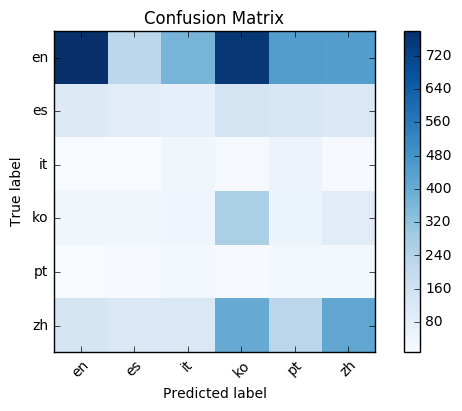

Average accuracy 0.276504271739
Building a logreg model with 69 code
Fold 1
Fold 2
Fold 3
Confusion matrix, without normalization


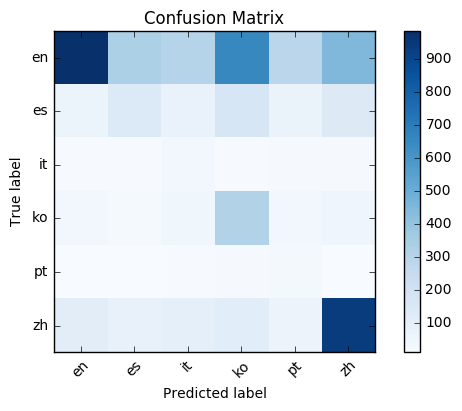

Average accuracy 0.418413902257
Building a logreg model with 91 all
Fold 1
Fold 2
Fold 3
Confusion matrix, without normalization


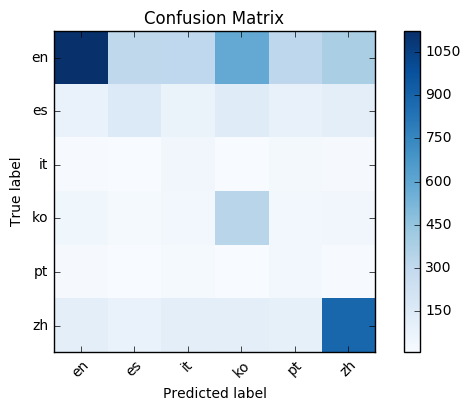

Average accuracy 0.431852682026


In [23]:
from sklearn.cross_validation import StratifiedKFold
from sklearn.neighbors import KNeighborsClassifier
from  sklearn.metrics import f1_score 
from sklearn.linear_model import LogisticRegression
from sklearn.metrics import confusion_matrix
import matplotlib.pyplot as plt
%matplotlib inline 
from plotcnf import plot_confusion_matrix

print 'Chance is', max(numpy.bincount(y))/float(len(y))


foldindices = StratifiedKFold(y)

labels = map(lambda x:x[0], sorted(lang_num_map.items(), key=lambda x:x[1]))  
# languages corresponding to class labels as a list

    
k = 70 #num neighbors for kNN

classifiers = [('logreg', LogisticRegression(class_weight='balanced', 
                                                             multi_class='multinomial', 
                                                             solver='lbfgs'))]  # no knn because it's too slow

for modelname, model in classifiers:
    for featname, X in [('time', Xtime), ('code', Xcode), ('all', Xall)]:
        print  'Building a', modelname, 'model with', X.shape[1], featname
    
        cvaccs = numpy.zeros(len(foldindices))
        #cvf1 = numpy.zeros(len(foldindices))
        for i, (trainidx, testidx) in enumerate(foldindices):
            print 'Fold', i+1
        
            ytrain = y[trainidx]
            ytest = y[testidx]
        
            Xtrain = X[trainidx, :]  
            Xtest = X[testidx, :]
            
            model.fit(Xtrain, ytrain)
            cvaccs[i] = model.score(Xtest, ytest)
        
            predictions = model.predict(Xtest)
            #cvf1[i] = f1_score(ytest, predictions)
            
            #print '****', modelname, cvaccs[i]
        #analyze last fold only
        cnf_matrix = confusion_matrix(ytest, predictions)  
        plot_confusion_matrix(cnf_matrix, labels)
        plt.show()
        
        print 'Average accuracy', numpy.mean(cvaccs)